<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/petru_dataResNet50_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint

In [ ]:
import platform
print(platform.system())

Linux


In [ ]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in kaggle data labels + image file paths

b) combine kaggle data labels and image file paths into one dataframe

c) load in the extra 486 image file paths

d) extract the speed and angle labels from the file path names

e) store that extra data in a pandas df and do the value normalisation

f) merge the kaggle and extra data dfs

g) EDA

h) convert the images to numerical RGB feature maps

i) split data into training-validation sets

j) data augmentation applied to training set

### 1a) load in kaggle data labels + image file paths

In [ ]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # OG data ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [ ]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [ ]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine the kaggle labels and image file paths into one dataframe

In [ ]:
kaggle_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
kaggle_df['speed'] = kaggle_df['speed'].round(6) # to get rid of floating point errors

In [ ]:
kaggle_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png


In [ ]:
kaggle_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) load in the extra 486 labels image file paths

In [ ]:
extradata_folder_path = '/home/apyba3/petru_data'

extradata_file_paths = [
    os.path.join(extradata_folder_path, f)
    for f in os.listdir(extradata_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

### 1d) extract the speed and angle labels from the file path names

image file path name follows the pattern: `randomnumber_angle_speed`

In [ ]:
# Regex pattern to extract angle and speed values
pattern = r'(\d+)_([\d]+)_([\d]+)\.png'

angle_value = []
speed_value = []

# Loop through file paths and extract angle and speed values
for file_path in extradata_file_paths:
    match = re.search(pattern, file_path)
    if match:
        # Extract random number, angle, and speed values
        random_number = match.group(1)
        angle_value.append(int(match.group(2)))
        speed_value.append(int(match.group(3)))

checking it has stored the labels correctly (check if the angle_value order matches that of the file path)

In [ ]:
print(angle_value[:3])
print(image_file_paths[:3])

[95, 100, 80]
['/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png', '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png', '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png']


### 1e) store that extra data in a pandas df and do the value normalisation

In [ ]:
extradata_df = pd.DataFrame({
    'angle': angle_value,
    'speed': speed_value,
    'image_file_paths': extradata_file_paths
})

# conversions (see kaggle data section)
extradata_df.loc[extradata_df['speed'] > 0, 'speed'] = 1
extradata_df['speed'] = pd.to_numeric(extradata_df['speed'], errors='coerce').fillna(0).astype(int)

extradata_df['angle'] = (extradata_df['angle'] - 50)/80

extradata_df.index = pd.RangeIndex(start=13799, stop=13799 + len(extradata_df), step=1)
extradata_df.index.name = 'image_id'

extradata_df.head()

,angle,speed,image_file_paths
image_id,,,
13799,0.5625,0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1,/home/apyba3/petru_data/1712923220525_100_50.png
13801,0.3750,1,/home/apyba3/petru_data/1712923068961_80_35.png
13802,0.6875,0,/home/apyba3/petru_data/1712921566265_105_0.png
13803,0.2500,1,/home/apyba3/petru_data/1712915924250_70_35.png


### 1f) merge the kaggle and extra data dfs

In [ ]:
merged_df = pd.concat([kaggle_df, extradata_df])
merged_df.loc[13797:13800]

,angle,speed,image_file_paths
image_id,,,
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png
13799,0.5625,0.0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1.0,/home/apyba3/petru_data/1712923220525_100_50.png


### 1g) EDA - angle column

In [ ]:
merged_df.value_counts('angle')

angle
0.5000    2172
0.7500    2172
0.6875    2049
0.6250    2000
0.5625    1644
0.4375    1520
0.8125    1162
0.3750     447
0.8750     308
0.3125     229
0.1875     119
0.2500     118
0.1250     114
0.0000      75
0.9375      74
0.0625      38
1.0000      38
Name: count, dtype: int64

note: imbalance datset

we want to remove the row containing the erroneous 1.428571 speed value

In [ ]:
cleaned_df = merged_df[merged_df['angle'] != 1.428571]

### 1h) convert images to numerical RGB feature maps

In [ ]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["angle"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(16)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [ ]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(16, 224, 224, 3) (16,)


### 1i) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [ ]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 714, validation size: 179


### 1j) Data Augmentation applied to training set

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Horizontal Flip
- Random Vertical Flip



In [ ]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  image = tf.image.stateless_random_flip_up_down(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
# augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
augmented_dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
# train_dataset = train_dataset.concatenate(augmented_dataset)
dataset = dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
# train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))
dataset = dataset.shuffle(buffer_size=len(cleaned_df))

count how many images are in the training set - 22016 with no extradata and 80-20 split

In [ ]:
total_images = 0
for image_batch, _ in dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

2025-03-23 00:27:03.246354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:72: Filling up shuffle buffer (this may take a while): 1635 of 14279
2025-03-23 00:27:04.746377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Total number of images in train_dataset: 28558


2025-03-23 00:27:05.222019: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


checking to see if whats been done was successful or needs debugging

2025-03-23 00:27:15.555156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:72: Filling up shuffle buffer (this may take a while): 1755 of 14279


image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.6875
image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.6875


2025-03-23 00:27:15.843059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


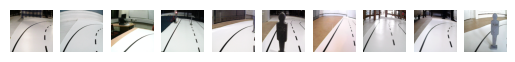

In [ ]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building - ResNet50 Transfer Learning

### 2a) Set up model architecture

In [ ]:
dropoutrate = 0.2
input_shape = (224,224,3)

In [ ]:
# Cell 29:
resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

model = tf.keras.Sequential([
  resnet50,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.trainable = True  # Make the entire model trainable

model.summary() # print the model

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,521 (92.15 MB)

 Trainable params: 24,102,401 (91.94 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [ ]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/home/apyba3/ResNet50/resnet50checkpoint.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Training loop
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=1,
    callbacks=[model_checkpoint]  # Include the ModelCheckpoint callback
)

Epoch 1/50


2025-03-23 00:31:39.730708: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.198 = (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %transpose.587, f32[64,3,7,7]{3,2,1,0} %transpose.588, f32[64]{0} %arg3.4), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_5_1/resnet50_1/conv1_conv_1/convolution" source_file="/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory whil

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2757321/876782938.py", line 13, in <module>

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.198 = (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %transpose.587, f32[64,3,7,7]{3,2,1,0} %transpose.588, f32[64]{0} %arg3.4), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_5_1/resnet50_1/conv1_conv_1/convolution" source_file="/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777472 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_195744]

In [ ]:
# dropoutrate = 0.2
# num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
# input_shape = (224,224,3)

# mbnet = tf.keras.applications.MobileNetV3Large(
#     input_shape=input_shape,
#     include_top=False,
#     weights='imagenet',
#     minimalistic=False
# )

# model = tf.keras.Sequential([
#   mbnet,
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dropout(dropoutrate),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dropout(dropoutrate),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(dropoutrate),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dropout(dropoutrate),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(1, activation='linear')
# ])

# model.build()

# mbnet.trainable = False # freeze the first layers to the imagenet weights

# model.summary() # print the model

### 2b) Define training step

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

### 2c) Training the model on the training set

In [ ]:
niter = 50

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # # Validation
    # val_batch_losses = []
    # val_batch_MSEs = []
    # for image_batch, label_batch in validation_dataset:
    #     val_loss, val_MSE = train_step(model, image_batch, label_batch)
    #     val_batch_losses.append(val_loss)
    #     val_batch_MSEs.append(val_MSE)

    # # Calculate average validation metrics
    # avg_val_loss = tf.reduce_mean(val_batch_losses)
    # avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    # vloss.append(avg_val_loss)
    # vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    # if it % 10 == 0:  # Check if (it + 1) is divisible by 10
    #     tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
    #         it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE))

2025-03-23 00:09:45.535640: W tensorflow/core/kernels/conv_ops_gpu.cc:330] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 16
in_depths: 64
out_depths: 256
in: 56
in: 56
data_format: 1
filter: 1
filter: 1
filter: 64
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_7.5 with 11539054592B RAM, 68 cores, 1545000KHz clock, 7000000KHz mem clock, 5767168B L2$"
version: 3

2025-03-23 00:09:45.536293: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at conv_ops_impl.h:1204 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777472 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying

NotFoundError: Graph execution error:

Detected at node sequential_2_1/resnet50_1/conv2_block1_0_conv_1/convolution defined at (most recent call last):
  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2757321/373689020.py", line 13, in <module>

  File "/tmp/ipykernel_2757321/961140981.py", line 7, in train_step

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/models/functional.py", line 584, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/models/functional.py", line 584, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/ops/nn.py", line 901, in conv

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 258, in conv

  File "/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777472 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng4{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 96993280 bytes.
  Profiling failure on CUDNN engine eng3{k11=2}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 605093888 bytes.
	 [[{{node sequential_2_1/resnet50_1/conv2_block1_0_conv_1/convolution}}]] [Op:__inference_train_step_64327]

In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression_resnet50.weights.h5')
# model.save_weights('/home/ppytr13/car_frozen.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [ ]:
dropoutrate = 0.2
num_classes = 1
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = True # UNFREEZE mbnet layers

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 3,261,233 (12.44 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [ ]:
model.load_weights('/home/apyba3/car_frozen_regression_mobv3.weights.h5')
# model.load_weights('/home/ppytr13/car_frozen.weights.h5')

Set up fine-tuning training

In [ ]:
LR = 0.0001 #deliberately smaller learning rate for fine tuning
optimizer = tf.optimizers.Adam(LR) #adam optimiser

In [ ]:
@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

In [ ]:
niter = 30

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # # Validation
    # val_batch_losses = []
    # val_batch_MSEs = []
    # for image_batch, label_batch in validation_dataset:
    #     val_loss, val_MSE = train_step(model, image_batch, label_batch)
    #     val_batch_losses.append(val_loss)
    #     val_batch_MSEs.append(val_MSE)

    # # Calculate average validation metrics
    # avg_val_loss = tf.reduce_mean(val_batch_losses)
    # avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    # vloss.append(avg_val_loss)
    # vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    # if it % 10 == 0:  # Check if (it + 1) is divisible by 10
    #     tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
    #         it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE))

2025-03-22 22:01:20.252811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 828 of 14279
2025-03-22 22:01:21.427303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
W0000 00:00:1742680895.375777 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742680895.380414 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742680895.381100 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742680895.381733 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742680895.408531 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742680895.409401 2746579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


iter: 0, train_loss: 0.010, train_MSE: 0.041


2025-03-22 22:02:52.241115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 880 of 14279
2025-03-22 22:02:52.406457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:04:01.975434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 892 of 14279
2025-03-22 22:04:01.984276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:05:08.117576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 876 of 14279
2025-03-22 22:05:08.356575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:06:14.493340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 87

iter: 10, train_loss: 0.006, train_MSE: 0.044


2025-03-22 22:13:53.448689: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-22 22:14:03.617502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 883 of 14279
2025-03-22 22:14:03.707885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:15:11.508634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 877 of 14279
2025-03-22 22:15:11.688805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:16:20.426104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 884 of 14279
2025-03-22 22:16:20.489405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03

iter: 20, train_loss: 0.005, train_MSE: 0.044


2025-03-22 22:26:24.262512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 874 of 14279
2025-03-22 22:26:24.543423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:27:31.000347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 863 of 14279
2025-03-22 22:27:31.559734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:28:38.807451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 874 of 14279
2025-03-22 22:28:39.122210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-22 22:29:46.380778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 86

In [ ]:
model.save_weights('car_unfrozen_regression_mobv3.weights.h5')
# model.save_weights('/home/ppytr13/car_unfrozen.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

I0000 00:00:1742682921.026793 2746582 service.cc:146] XLA service 0x7fb015a9b510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742682921.026938 2746582 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1742682921.026947 2746582 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-22 22:35:21.566490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3:51 7s/step

I0000 00:00:1742682927.198671 2746582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['angle'])

In [ ]:
predictions_df.head()

,angle
0,0.564235
1,0.770255
2,0.089251
3,0.105641
4,0.157410


In [ ]:
predictions_df['angle'].value_counts()

angle
 0.104878    1
 0.564235    1
 0.770255    1
 0.089251    1
 0.105641    1
 0.157410    1
 0.733514    1
 0.720006    1
 0.775421    1
 0.595013    1
 0.495358    1
 0.482492    1
 0.741372    1
 0.467921    1
 0.547928    1
 0.273957    1
 0.662391    1
 0.518453    1
 0.729182    1
 0.438258    1
 0.100113    1
 0.917309    1
 0.083302    1
 0.250500    1
 0.733548    1
 0.725242    1
 0.781992    1
 0.627124    1
 0.737834    1
 0.537647    1
 0.646249    1
 0.700442    1
 0.734939    1
 0.086361    1
 0.522180    1
 0.695654    1
 0.570149    1
 0.489313    1
 0.693735    1
 0.591150    1
 0.283893    1
 0.803771    1
 0.779166    1
 0.816172    1
 0.622035    1
 0.448835    1
 0.672856    1
 0.501566    1
 0.628237    1
 0.318401    1
 0.786581    1
 0.506678    1
 0.641919    1
 0.056355    1
 0.157306    1
 0.049518    1
 0.534424    1
 0.201620    1
 0.514681    1
 0.437292    1
 0.475499    1
 0.479032    1
 0.492126    1
 0.195413    1
 0.578841    1
 0.276897    1
 0.4

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_angleregression_predictions_novalidation_extraaug_petru.csv')